#Question 1

**Importing Libraries**

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn import model_selection
from sklearn.linear_model import Ridge, Lasso
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV, cross_val_score

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
data = pd.read_csv("https://raw.githubusercontent.com/ta-verma/DataSets/master/abalone.csv")

In [0]:
scaler = StandardScaler()
onehot = OneHotEncoder()

In [5]:
print(data.shape)
data.head()

(4177, 9)


,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [6]:
data.dtypes

Sex                object
Length            float64
Diameter          float64
Height            float64
Whole weight      float64
Shucked weight    float64
Viscera weight    float64
Shell weight      float64
Rings               int64
dtype: object

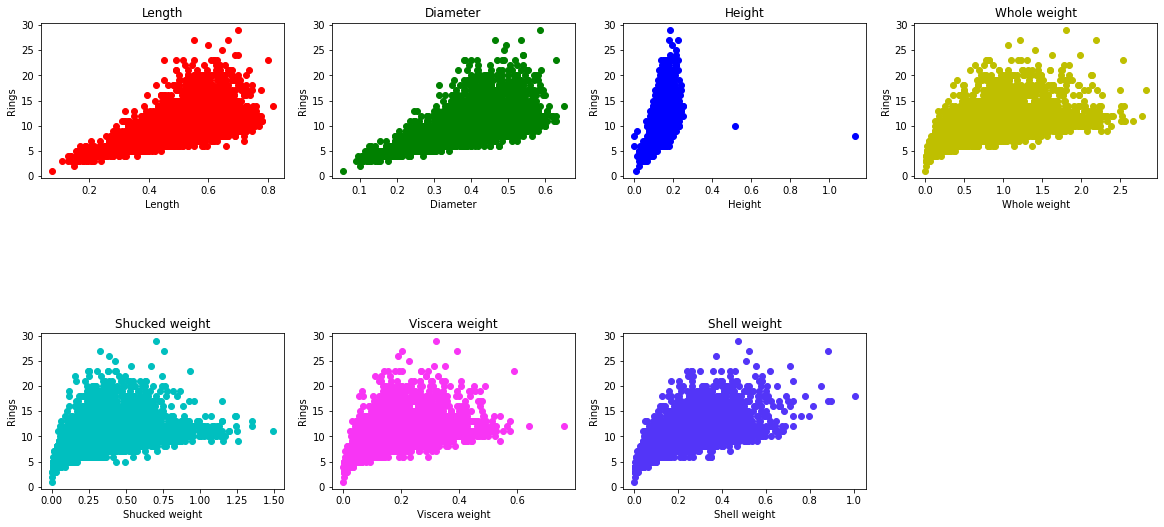

In [7]:
fig = plt.figure(figsize=(20,20))
i=1
colmap = {1:'r', 2:'g', 3:'b', 4:'y', 5:'c', 6:'#F835F5', 7:'#5335F8'}
for col in data.columns:
  if col not in ['Rings','Sex']:
    plt.subplot(4, 4, i)
    plt.title(col)
    plt.scatter(data[col],data['Rings'],color = colmap[i] )
    plt.xlabel(col)
    plt.ylabel('Rings')
    i=i+1

plt.subplots_adjust(hspace=1)
plt.show()

**Handling Categorical Data**

In [0]:
columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(), ['Sex'])], remainder='passthrough')
dataset = columnTransformer.fit_transform(data)

In [0]:
X = dataset[:,:-1]
Y = dataset[:,-1].reshape(len(X), 1)

**Train Test Split (80-20)**

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=5) 

**Feature Scaling**

In [0]:
X_train[:,4:] = scaler.fit_transform(X_train[:,4:])
X_test[:,4:] = scaler.transform(X_test[:,4:])

**Linear Regression**

with cost history

In [0]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def linear_gradient_descent(X_train, y_train, X_test, y_test, iterations, alpha, lmda=None, reg=None):   # with cost history
    n_samples, n_features = X_train.shape
    B = np.zeros(n_features).reshape(n_features, 1)
    train_rmse_history = [0] * iterations
    test_rmse_history = [0] * iterations
    
    for i in range(iterations):
        y_pred = X_train.dot(B)
        
        if reg == 'l1' and lmda != None:
          gradient = ((((y_pred - y_train).T).dot(X_train)).T + ((lmda/2) * np.sign(B))) / n_samples
        
        elif reg == 'l2' and lmda != None:
          gradient = ((((y_pred - y_train).T).dot(X_train)).T + (lmda * B)) / n_samples
        
        else:
          gradient = ((((y_pred - y_train).T).dot(X_train)).T) / n_samples
        
        B -=  alpha * gradient
        train_rmse_history[i] = np.sqrt(np.sum((y_pred-y_train) ** 2) / n_samples)
        test_rmse_history[i] = rmse(X_test.dot(B), y_test)

    return B, train_rmse_history, test_rmse_history



without cost history

In [0]:
def simple_linear_gradient_descent(X, y, iterations, alpha, lmda=None, reg=None):                # without cost history
    X = np.concatenate((np.ones(len(X)).reshape(len(X), 1), X), axis = 1)
    n_samples, n_features = X.shape
    B = np.zeros(n_features).reshape(n_features, 1)

    
    for i in range(iterations):
        y_pred = X.dot(B)
        
        if reg == 'l1' and lmda != None:
          gradient = ((((y_pred - y).T).dot(X)).T + ((lmda/2) * np.sign(B))) / n_samples
        
        elif reg == 'l2' and lmda != None:
          gradient = ((((y_pred - y).T).dot(X)).T + (lmda * B)) / n_samples
        
        else:  
          gradient = ((((y_pred - y).T).dot(X)).T) / n_samples
        B -=  alpha * gradient

    return B

def predict(X, B):
  X = np.concatenate((np.ones(len(X)).reshape(len(X), 1), X), axis = 1)
  return X.dot(B)

**RMSE Curve**

In [0]:
def plot_rmse(epochs, train, test, title = ''):
  plt.plot(range(epochs), train, c='r', label='Training RMSE')
  plt.plot(range(epochs), test, c='b', label='Testing RMSE')
  plt.title(title)
  plt.xlabel('Epochs')
  plt.ylabel('RMSE')
  plt.legend()
  plt.show()

**Gradient Descent**

In [0]:
alpha = 0.01
iter_ = 1000
B, train_cost_history, test_cost_history = linear_gradient_descent(X_train, y_train, X_test, y_test, iter_, alpha)

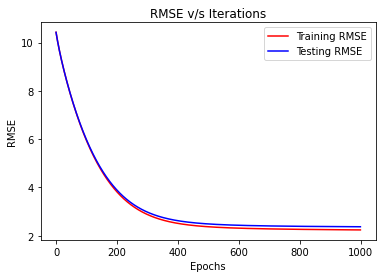

In [16]:
plot_rmse(iter_, train_cost_history, test_cost_history, 'RMSE v/s Iterations')

In [17]:
train_cost_history[-1], test_cost_history[-1]

(2.2416126828072884, 2.3728716352744104)

**<h2>Normal Equation</h2>**

In [0]:
def normal_equation(X, y):
    return np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

In [0]:
B_normal = normal_equation(X_train, y_train)
normal_train_rmse = rmse(X_train.dot(B_normal), y_train)
normal_test_rmse = rmse(X_test.dot(B_normal), y_test)


**Comparing RMSE**

In [20]:
rmse_df = pd.DataFrame([[train_cost_history[-1], test_cost_history[-1]], 
                        [normal_train_rmse, normal_test_rmse]], 
                       columns=['Training Set', 'Testing Set'], index=['Gradient Descent', 'Normal Equation'])

print('RMSE of Gradient Descent and Normal Equation\n')
from tabulate import tabulate
print(tabulate(rmse_df, headers='keys', tablefmt='pretty'))

RMSE of Gradient Descent and Normal Equation

+------------------+--------------------+--------------------+
|                  |    Training Set    |    Testing Set     |
+------------------+--------------------+--------------------+
| Gradient Descent | 2.2416126828072884 | 2.3728716352744104 |
| Normal Equation  | 2.1650743991218957 |  2.30134062589164  |
+------------------+--------------------+--------------------+


RMSE value of Normal equation is better than the Gradient descent method it is because Gradient descent is iterative process while Normal equation solve B(theta) analytically. Therefore, For some linear regression problems Normal equation provides better solution.

#Question 2

**<h2>Lasso Regression or L1**

In [0]:
lasso = Lasso(max_iter=10000, random_state=5)

alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
tuned_parameters = [{'alpha': alphas }]

n_folds = 5
grid_l1 = GridSearchCV(estimator = lasso, param_grid= tuned_parameters, cv=n_folds, refit=True)

In [22]:
grid_l1.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=10000, normalize=False, positive=False,
                             precompute=False, random_state=5,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 0.e+00])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [23]:
grid_l1.best_score_

0.5346204140830038

**The optimal regularization parameter for L1**

In [24]:
grid_l1.best_params_

{'alpha': 0.001}

**Hyperparameter**

In [25]:
grid_l1.best_estimator_

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=5,
      selection='cyclic', tol=0.0001, warm_start=False)

**<h2>Ridge Regression or L2**

In [0]:
ridge = Ridge()

alphas = np.array([1,0.1,0.01,0.001,0.0001,0])

grid_l2 = GridSearchCV(estimator=ridge, param_grid=dict(alpha=alphas))

In [27]:
grid_l2.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 0.e+00])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [28]:
grid_l2.best_score_

0.5343480744745012

**The optimal regularization parameter for L2**

In [29]:
grid_l2.best_params_

{'alpha': 1.0}

**Hyperparameter**

In [30]:
grid_l2.best_estimator_

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

**Optimal Parameter**

In [31]:
x = PrettyTable(["Regularization", "Alpha"])
x.add_row(["Lasso or L1", grid_l1.best_estimator_.alpha])
x.add_row(["Ridge or L2", grid_l2.best_estimator_.alpha])
print(x)

+----------------+-------+
| Regularization | Alpha |
+----------------+-------+
|  Lasso or L1   | 0.001 |
|  Ridge or L2   |  1.0  |
+----------------+-------+


<h2>Applying Gradient Descent with L1 and L2 parameters

In [0]:
alpha = 0.01
iter_ = 1000
lmda_l1 = grid_l1.best_estimator_.alpha
lmda_l2 = grid_l2.best_estimator_.alpha

B_l1, train_history_l1, test_history_l1 = linear_gradient_descent(X_train, y_train, X_test, y_test, iter_, alpha, lmda_l1, reg='l1')
B_l2, train_history_l2, test_history_l2 = linear_gradient_descent(X_train, y_train, X_test, y_test, iter_, alpha, lmda_l2, reg='l2')

Plots of RMSE v/s iteration For L1 and L2

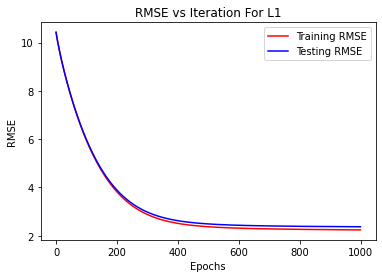

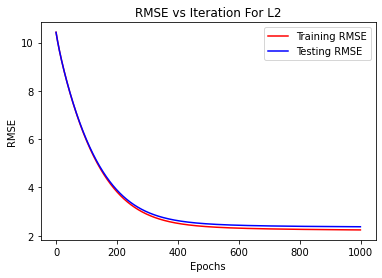

In [33]:
plot_rmse(iter_, train_history_l1, test_history_l1, 'RMSE vs Iteration For L1')
print('\n\n')
plot_rmse(iter_, train_history_l2, test_history_l2, 'RMSE vs Iteration For L2')

In [34]:
rmse_df = pd.DataFrame([[train_history_l1[-1], test_history_l1[-1]], 
                        [train_history_l2[-1], test_history_l2[-1]]], 
                       columns=['Training Set', 'Testing Set'], index=['L1', 'L2'])

print('RMSE of Regularized Linear Regression\n')
from tabulate import tabulate
print(tabulate(rmse_df, headers='keys', tablefmt='pretty'))

RMSE of Regularized Linear Regression

+----+-------------------+--------------------+
|    |   Training Set    |    Testing Set     |
+----+-------------------+--------------------+
| L1 | 2.241612772067303 | 2.3728717114059803 |
| L2 | 2.241870102312401 | 2.3731179765164074 |
+----+-------------------+--------------------+


#Question 3

**Importing DataSet**

In [0]:
df = pd.read_csv("https://raw.githubusercontent.com/ta-verma/DataSets/master/headbrain.csv").drop(["Gender","Age Range"], axis=1)

X = df["Head Size(cm^3)"].values.reshape(len(df), 1)
y = df["Brain Weight(grams)"].values.reshape(len(df), 1)

Feature Scaling

In [0]:
X = scaler.fit_transform(X)

**Defining Plot of Regression Line**

In [0]:
def plot_regression_line(X, y, y_pred, title=None):
  plt.scatter(X,y ,color = 'c' ,label = "Scatter Plot")
  plt.plot(X,y_pred_linear ,color = 'r' , label = "Regression Line")
  plt.title(title)
  plt.xlabel("Head Size(cm^3)")
  plt.ylabel("Brain Weight(grams)")
  plt.legend()
  plt.show()

**<h3>Simple Linear Regression**

B0 =  [1282.87341772]
B1 =  [96.01736367]



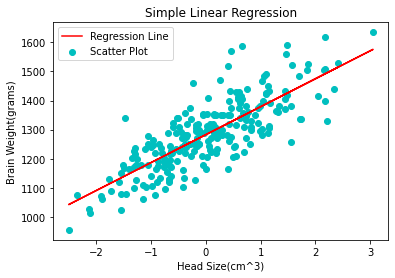

RMSE : 72.1206213783709


In [38]:
X_mean = np.mean(X)
Y_mean = np.mean(y)
n = len(X)

num = 0
den = 0
for i in range(n):
    num += (X[i]-X_mean) * (y[i] - Y_mean)
    den += (X[i]-X_mean) ** 2

B1 = num/den
B0 = Y_mean - B1 * X_mean
print("B0 = ",B0)
print("B1 = ",B1)
print()

y_pred_linear = B1 * X + B0

plot_regression_line(X, y, y_pred_linear, "Simple Linear Regression")

print("RMSE :",rmse(y, y_pred_linear))

**<h2> Linear Regression with Gradient Descent**

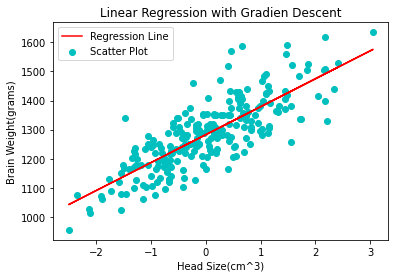

In [39]:
epoch = 100
alpha = 0.1

B = simple_linear_gradient_descent(X, y, epoch, alpha )
y_pred = predict(X, B)

plot_regression_line(X, y, y_pred, "Linear Regression with Gradien Descent")

**Lasso Regression**


{'alpha': 1e-15}


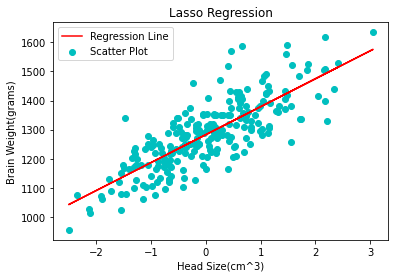

In [40]:
lasso = Lasso()

parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]}

lasso_regressor = GridSearchCV(lasso, parameters,scoring='neg_mean_squared_error', cv=5)
lasso_regressor.fit(X, y)
print()
print(lasso_regressor.best_params_)

epoch = 100
alpha = 0.1
lmda = lasso_regressor.best_estimator_.alpha
B = simple_linear_gradient_descent(X, y, epoch, alpha, lmda, reg='l1' )
y_pred = predict(X, B)

plot_regression_line(X, y, y_pred, "Lasso Regression")

**Ridge Regression**

{'alpha': 1e-15}


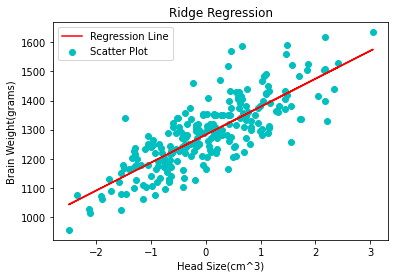

In [41]:
ridge = Ridge()

parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]}

ridge_regressor = GridSearchCV(ridge, parameters,scoring='neg_mean_squared_error', cv=5)
ridge_regressor.fit(X, y)
print(ridge_regressor.best_params_)

epoch = 100
alpha = 0.1
lmda = ridge_regressor.best_estimator_.alpha
B = simple_linear_gradient_descent(X, y, epoch, alpha, lmda, reg='l2' )
y_pred = predict(X, B)

plot_regression_line(X, y, y_pred, "Ridge Regression")